In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43135")
client

<Client: 'tcp://127.0.0.1:43135' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:39069' processes=2 threads=10, memory=39.34 GiB>

In [2]:
sdir = '/tank/spectre/tuchida/MLI/'

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import griddata
import xwavelet
import gcm_filters
import os.path as op
import gsw
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [5]:
reg = 2
dss = cat.eNATL60(region=str(reg),datatype='surface_hourly', season='fma'
                 ).to_dask()
dss.coords['day'] = ('time_counter',np.repeat(np.arange(len(dss.time_counter)//24),
                                              24))
dss = dss.groupby('day').mean('time_counter',skipna=True)

dss

<xarray.Dataset>
Dimensions:   (y: 735, x: 607, day: 89)
Coordinates: (12/14)
    depth     (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1f       (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1t       (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1u       (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e1v       (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    e2f       (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    ...        ...
    e2v       (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    lon       (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    nav_lat   (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
    nav_lon   (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
  * day       (day) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask     (day, y, x) int8 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    qt_oce    (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    somecrty  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sometauy  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sosaline  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sossheig  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    ...        ...
    sowaflup  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sozocrtx  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    sozotaux  (day, y, x) float32 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    tmask     (day, y, x) int8 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    umask     (day, y, x) int8 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>
    vmask     (day, y, x) int8 dask.array<chunksize=(1, 735, 607), meta=np.ndarray>

In [6]:
dsi = cat.eNATL60(region=str(reg),datatype='interior_daily', season='fma'
                 ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),
                                  depthu=slice(None,-1)
                                 ).chunk({'deptht':5,'depthw':5,
                                          'depthv':5,'depthu':5}
                                        )
dsi

<xarray.Dataset>
Dimensions:       (y: 735, x: 607, deptht: 106, depthu: 106, depthv: 106,
                   depthw: 107, time_counter: 89)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 607), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 607), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>

In [7]:
YC = dss.lat.mean('x')
XC = dss.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')

In [9]:
taux = xr.DataArray(dss.sozotaux.data, dims=['time','YC','XG'],
                    coords={'YC':YC.data,'XG':XG.data}
                   )
tauy = xr.DataArray(dss.sometauy.data, dims=['time','YG','XC'],
                    coords={'YG':YG.data,'XC':XC.data}
                   )
fwf  = xr.DataArray(dss.sowaflup.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )
Q    = xr.DataArray(dss.qt_oce.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

In [8]:
# v  = xr.DataArray(dsi.vomecrty.data, dims=['time','Z','YG','XC'],
#                   coords={'Z':dsi.depthv.data,'YG':YG.data,'XC':XC.data}
#                  )
# u  = xr.DataArray(dsi.vozocrtx, dims=['time','Z','YC','XG'],
#                   coords={'Z':dsi.depthu.data,'YC':YC.data,'XG':XG.data}
#                  )
w  = xr.DataArray(dsi.vovecrtz.data, dims=['time','Zp1','YC','XC'],
                  coords={'Zp1':dsi.depthw.data,'YC':YC.data,'XC':XC.data}
                 )
CT = xr.DataArray(dsi.votemper.data, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )
SA = xr.DataArray(dsi.vosaline, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )

In [9]:
ds = CT.to_dataset(name='CT')
ds['SA'] = SA
# ds['U'] = u
# ds['V'] = v
ds['W'] = w
# ds['taux'] = taux  # N/m2 = (kg.m/s2)/m2
# ds['tauy'] = tauy  # N/m2
# ds['Ffw'] = fwf    # kg/m2/s
# ds['Q'] = Q        # W/m2 = (N.m/s)/m2 = (kg.m2/s3)/m2
ds.coords['maskC'] = xr.DataArray(dsi.tmask.data, dims=['Z','YC','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskW'] = xr.DataArray(dsi.umask.data, dims=['Z','YC','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XG':XG.data}
                          )
ds.coords['maskS'] = xr.DataArray(dsi.vmask.data, dims=['Z','YG','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XC':XC.data}
                          )
ds.coords['maskG'] = xr.DataArray(dsi.fmask.data, dims=['Z','YG','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XG':XG.data}
                          )
ds.coords['DXU'] = xr.DataArray(dss.e1u.data,
                   dims=['YC','XG'], 
                   coords={'YC':YC.data,'XG':XG.data}
                  )
ds.coords['DYU'] = xr.DataArray(dss.e2u.data,
                   dims=['YC','XG'], 
                   coords={'YC':YC.data,'XG':XG.data}
                  )
ds.coords['DXV'] = xr.DataArray(dss.e1v.data,
                   dims=['YG','XC'], 
                   coords={'YG':YG.data,'XC':XC.data}
                  )
ds.coords['DYV'] = xr.DataArray(dss.e2v.data,
                   dims=['YG','XC'], 
                   coords={'YG':YG.data,'XC':XC.data}
                  )
ds.coords['DXT'] = xr.DataArray(dss.e1t.data,
                   dims=['YC','XC'], 
                   coords={'YC':YC.data,'XC':XC.data}
                  )
ds.coords['DYT'] = xr.DataArray(dss.e2t.data,
                   dims=['YC','XC'], 
                   coords={'YC':YC.data,'XC':XC.data}
                  )
ds.coords['DXF'] = xr.DataArray(dss.e1f.data,
                   dims=['YG','XG'], 
                   coords={'YG':YG.data,'XG':XG.data}
                  )
ds.coords['DYF'] = xr.DataArray(dss.e2f.data,
                   dims=['YG','XG'], 
                   coords={'YG':YG.data,'XG':XG.data}
                  )

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "Z": {"center": "Z",  "outer":"Zp1"}
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> outer
  * outer    Zp1 --> center

In [ ]:
sig0 = xr.apply_ufunc(gsw.sigma0, ds.SA, ds.CT,
                      dask='parallelized', output_dtypes=[float,]
                     )
grav = 9.81
rho0 = 1e3
b = -(sig0.where(ds.maskC!=0.).chunk({'time':1,'Z':3,
                                      'YC':100,'XC':100}) 
      * grav / rho0
     )
b.to_dataset(name='BUOY').to_zarr(op.join(sdir,'eNATL60/region%02d/Buoy_fma.zarr' 
                                          % reg), mode='w')

In [11]:
b = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Buoy_fma.zarr' 
                         % reg)
                ).BUOY.chunk({'time':1,'Z':1})

w = grid.interp(ds.W.chunk({'Zp1':-1}),'Z',boundary='extend'
               ).where(ds.maskC!=0.).load().chunk({'time':1,'Z':1})

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(


In [ ]:
area = xr.DataArray((dss.e1t * dss.e2t).data, dims=['YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   ).load()

In [11]:
dxw = xr.DataArray(dss.e1u.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ).load() # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ).load() # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ).load() # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['YC','XC'],
                   coords={'YC':YC.data, 'XC':XC.data}
                  ).load() # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.zeros_like(ds.CT.isel(time=0)
                        ).chunk({'Z':1})
wet_mask[:,1:-1,1:-1] = dsi.tmask[:,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask).chunk({'Z':1})
kappa_w[:,1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask).chunk({'Z':1})
kappa_s[:,1:-1,1:-1] += 1.

filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'YC':-1,'XC':-1}), 
        'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
        'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
        'area': area.chunk({'YC':-1,'XC':-1}), 
        'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
        'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
    }
)

In [ ]:
wm = filter_30km.apply(w.chunk({'YC':-1,'XC':-1}), 
                       dims=['YC', 'XC']
                      ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
bm = filter_30km.apply(b.chunk({'YC':-1,'XC':-1}), 
                       dims=['YC', 'XC']
                      ).isel(YC=slice(1,-1),XC=slice(1,-1)
                            ).reset_coords(drop=True).chunk({'YC':100,'XC':100})
dsave = wm.to_dataset(name='WVEL')
dsave['BUOY'] = bm
dsave.to_zarr(op.join(sdir,'eNATL60/region%02d/Meso_W-B.zarr' 
                      % reg), mode='w')

In [12]:
dsm = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/Meso_W-B.zarr' 
                           % reg)
                  )
tskp = 10; kskp = 3
ws = (w.isel(YC=slice(1,-1),XC=slice(1,-1))
      - dsm.WVEL)[::tskp,::kskp].reset_coords(drop=True).chunk({'Z':3,'YC':100,'XC':100})
bs = (b.isel(YC=slice(1,-1),XC=slice(1,-1)) 
      - dsm.BUOY)[::tskp,::kskp].reset_coords(drop=True).chunk({'Z':3,'YC':100,'XC':100})
ws

<xarray.DataArray (time: 9, Z: 36, YC: 733, XC: 605)>
dask.array<rechunk-merge, shape=(9, 36, 733, 605), dtype=float32, chunksize=(1, 3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 30.52 30.53 30.55 30.56 ... 40.36 40.37 40.38 40.4
  * XC       (XC) float32 -53.54 -53.53 -53.51 -53.49 ... -43.49 -43.48 -43.46
  * Z        (Z) float32 0.4805 4.187 9.318 15.89 ... 837.3 885.6 934.9 985.3
Dimensions without coordinates: time

# Interpolate to monotonic metric grid

In [17]:
XT = grid.cumsum(ds.DXU,'X',boundary='extend'
                ).isel(YC=slice(1,-1),XC=slice(1,-1))
YT = grid.cumsum(ds.DYV,'Y',boundary='extend'
                ).isel(YC=slice(1,-1),XC=slice(1,-1))
ny,nx = XT.shape
xT = (XT - XT.isel(XC=nx//2)).values.flatten()
yT = (YT - YT.isel(YC=ny//2)).values.flatten()
dx = ds.DXT.isel(YC=slice(1,-1),XC=slice(1,-1)).min().values
dy = ds.DYT.isel(YC=slice(1,-1),XC=slice(1,-1)).min().values
yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
xx = np.arange(-nx*dx/2,nx*dx/2,dx)

In [21]:
xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
Aterp = xr.DataArray(griddata((xT, yT), 
                              area.isel(YC=slice(1,-1),XC=slice(1,-1)).values.flatten(),
                              (xxx, yyy) 
                             ).T, 
                     dims=['YC','XC'],
                     coords={'YC':yy,'XC':xx}
                    )
Aterp

<xarray.DataArray (YC: 733, XC: 605)>
array([[2509188.55884018, 2509211.64565499, 2509235.73533725, ...,
        2523232.11159365, 2523243.61687107, 2523254.75885181],
       [2508498.27969814, 2508520.62114645, 2508544.13392635, ...,
        2522581.03707757, 2522590.66195641, 2522599.89089536],
       [2507803.67932292, 2507824.26221053, 2507846.36359766, ...,
        2521929.84842836, 2521937.80765777, 2521945.36313099],
       ...,
       [1983889.15523942, 1983934.80411493, 1983983.84035401, ...,
        2032932.98887694, 2032984.56036815, 2033037.2068331 ],
       [1983170.61718694, 1983224.3876087 , 1983280.74777521, ...,
        2032249.06367609, 2032294.93030906, 2032342.39244767],
       [1982452.20617147, 1982514.79205937, 1982579.21807033, ...,
        2031564.07554873, 2031603.87822211, 2031645.88062563]])
Coordinates:
  * YC       (YC) float64 -5.098e+05 -5.084e+05 -5.07e+05 ... 5.07e+05 5.084e+05
  * XC       (XC) float64 -4.29e+05 -4.275e+05 ... 4.261e+05 4.275e+05

In [24]:
Wterp = xr.DataArray(np.zeros_like(w[::tskp,::kskp].isel(YC=slice(1,-1),XC=slice(1,-1))), 
                     dims=['time','Z','YC','XC'],
                     coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                    )
Bterp = xr.DataArray(np.zeros_like(b[::tskp,::kskp].isel(YC=slice(1,-1),XC=slice(1,-1))), 
                     dims=['time','Z','YC','XC'],
                     coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                    )

for tt in range(len(ds.time[::tskp])):
    for zz in range(len(ds.Z[::kskp])):
        Wterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                             (w[::tskp,::kskp] * area
                                             ).isel(time=tt,Z=zz,
                                                    YC=slice(1,-1),XC=slice(1,-1)
                                                   ).values.flatten(),
                                             (xxx, yyy) 
                                            ).T 
        Bterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                             (b[::tskp,::kskp] * area
                                             ).isel(time=tt,Z=zz,
                                                    YC=slice(1,-1),XC=slice(1,-1)
                                                   ).values.flatten(),
                                             (xxx, yyy) 
                                            ).T 
    print(tt)

Wterp = (Wterp / Aterp).chunk({'time':1,'Z':1})
Bterp = (Bterp / Aterp).chunk({'time':1,'Z':1})

0
1
2
3
4
5
6
7
8


In [25]:
dsave = Wterp.to_dataset(name='W')
dsave['B'] = Bterp
dsave.to_zarr(op.join(sdir,'eNATL60/region%02d/W-B_interped_fma.zarr' 
                      % reg))

In [29]:
Wmterp = xr.DataArray(np.zeros_like(dsm.WVEL[::tskp,::kskp]), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Bmterp = xr.DataArray(np.zeros_like(dsm.BUOY[::tskp,::kskp]), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Wsterp = xr.DataArray(np.zeros_like(ws), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Bsterp = xr.DataArray(np.zeros_like(bs), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )

for tt in range(len(ds.time[::tskp])):
    for zz in range(len(ds.Z[::kskp])):
        Wmterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (dsm.WVEL[::tskp,::kskp]
                                               * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                                              ).isel(time=tt,Z=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        Bmterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (dsm.BUOY[::tskp,::kskp]
                                               * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                                              ).isel(time=tt,Z=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        Wsterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (ws * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                                              ).isel(time=tt,Z=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        Bsterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (bs * area.isel(YC=slice(1,-1),XC=slice(1,-1))
                                              ).isel(time=tt,Z=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
    print(tt)
                        
Wmterp = (Wmterp / Aterp).chunk({'time':1,'Z':1})
Wsterp = (Wsterp / Aterp).chunk({'time':1,'Z':1})
Bmterp = (Bmterp / Aterp).chunk({'time':1,'Z':1})
Bsterp = (Bsterp / Aterp).chunk({'time':1,'Z':1})

0
1
2
3
4
5
6
7
8


In [30]:
dsave = Wmterp.to_dataset(name='Wm')
dsave['Ws'] = Wsterp
dsave['Bm'] = Bmterp
dsave['Bs'] = Bsterp
dsave.to_zarr(op.join(sdir,'eNATL60/region%02d/W-B_SM_interped_fma.zarr'
                      % reg))

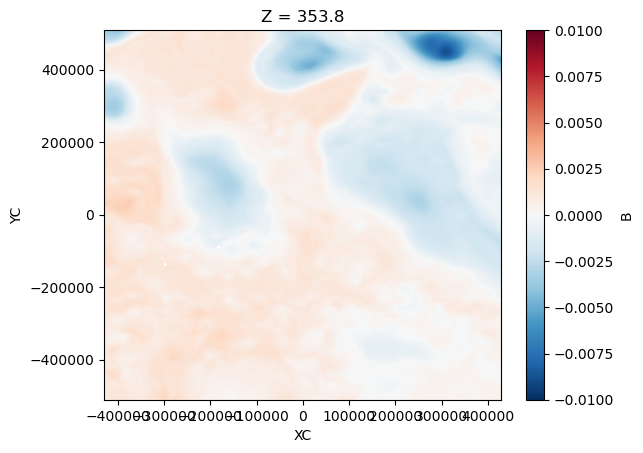

In [11]:
dsr = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/W-B_interped_fma.zarr' % reg))
wp = dsr.W - dsr.W.mean(['YC','XC'],skipna=True)
bp = dsr.B - dsr.B.mean(['YC','XC'],skipna=True)
bp.isel(time=3,Z=20).plot(vmax=1e-2)

In [12]:
kwargs = {'true_phase':True, 'true_amplitude':False}
Fwb = xrft.isotropic_cross_spectrum(wp.fillna(0.), bp.fillna(0.), 
                                    dim=['YC','XC'], detrend='constant',
                                    window='hann', window_correction=True, 
                                    nfactor=4, truncate=True,
                                    **kwargs
                         )
Fwb

<xarray.DataArray (time: 9, Z: 36, freq_r: 106)>
dask.array<getitem, shape=(9, 36, 106), dtype=complex128, chunksize=(1, 1, 106), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 0.4805 4.187 9.318 15.89 ... 837.3 885.6 934.9 985.3
  * freq_r   (freq_r) float64 2.224e-06 5.139e-06 ... 0.0003479 0.0003513
Dimensions without coordinates: time

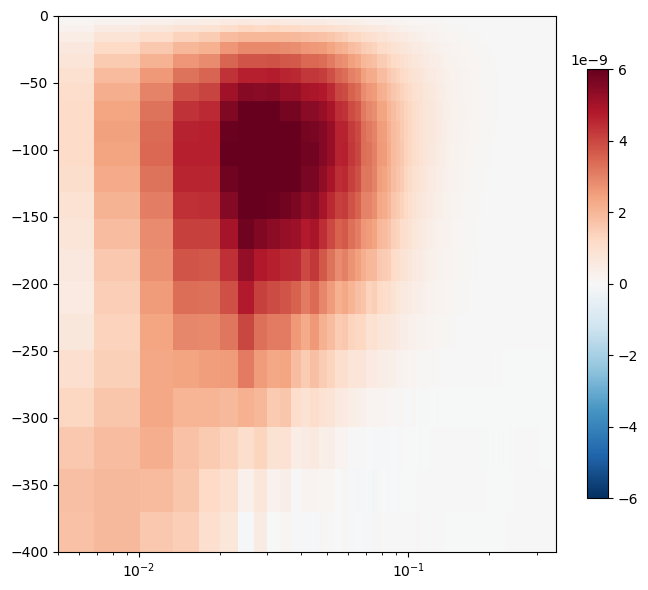

In [20]:
fig, ax = plt.subplots(figsize=(7,6))
fig.set_tight_layout(True)
im = ax.pcolormesh(Fwb.freq_r*1e3, -Fwb.Z, Fwb.real.mean('time')*Fwb.freq_r*2*np.pi, 
                   cmap='RdBu_r', rasterized=True,
                   vmax=6e-9, vmin=-6e-9)
ax.set_ylim([-400,0])
ax.set_xlim([5e-3,None])
ax.set_xscale('log')
fig.colorbar(im, ax=ax, shrink=.8)
plt.savefig(op.join(sdir,'Figs/eNATL60-Fwbtot-region%02d-fma.pdf' % reg))

In [13]:
xo = 50e3
s = xr.DataArray(Fwb.freq_r.data**-1 / xo, dims='scale',
                 coords={'scale':Fwb.freq_r.data**-1 / xo}
                )
print(s)

<xarray.DataArray (scale: 106)>
array([8.99258714, 3.89155254, 2.37145465, 1.70018526, 1.32625761,
       1.0864464 , 0.92177176, 0.8000693 , 0.7061657 , 0.63172288,
       0.57132037, 0.52159226, 0.48005447, 0.44480849, 0.41424669,
       0.38762909, 0.36409139, 0.343136  , 0.32453576, 0.30790548,
       0.29287924, 0.27933339, 0.26695784, 0.25553698, 0.24511783,
       0.2355032 , 0.22660596, 0.21839849, 0.21075767, 0.20360098,
       0.19691869, 0.19069947, 0.18481933, 0.17928912, 0.17412356,
       0.16920138, 0.16454247, 0.16017719, 0.15600612, 0.15204007,
       0.14830634, 0.14474384, 0.14134575, 0.13808211, 0.1349732 ,
       0.13201035, 0.12915769, 0.12645984, 0.12386802, 0.12135662,
       0.11894731, 0.11663306, 0.11440645, 0.11226316, 0.11020849,
       0.10823002, 0.10632067, 0.10446903, 0.10267779, 0.10095299,
       0.09927836, 0.09766336, 0.09611001, 0.09460001, 0.09313373,
       0.09170888, 0.09032077, 0.08898536, 0.08768803, 0.08642552,
       0.08520493, 0.08400826,

In [18]:
maskb = xr.DataArray(np.ma.masked_invalid(bp.isel(time=0)).mask,
                     dims=bp.isel(time=0).dims, coords=bp.isel(time=0).coords
                    )
Wwb = xwavelet.wvlt_cross_spectrum(wp.where(maskb!=1.).chunk({'YC':100,'XC':100}), 
                                   bp.chunk({'YC':100,'XC':100}), 
                                   s, dim=['YC','XC']
                            )
Wwb

<xarray.DataArray (time: 9, Z: 36, angle: 8, scale: 106)>
dask.array<truediv, shape=(9, 36, 8, 106), dtype=float64, chunksize=(1, 1, 8, 106), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 0.4805 4.187 9.318 15.89 ... 837.3 885.6 934.9 985.3
  * angle    (angle) float64 0.0 0.3927 0.7854 1.178 1.571 1.963 2.356 2.749
  * scale    (scale) float64 4.496e+05 1.946e+05 ... 2.874e+03 2.847e+03
Dimensions without coordinates: time

In [14]:
dtheta = np.pi/len(Wwb.angle)
Wwb_int = Wwb.sum('angle').mean('time').compute() * dtheta

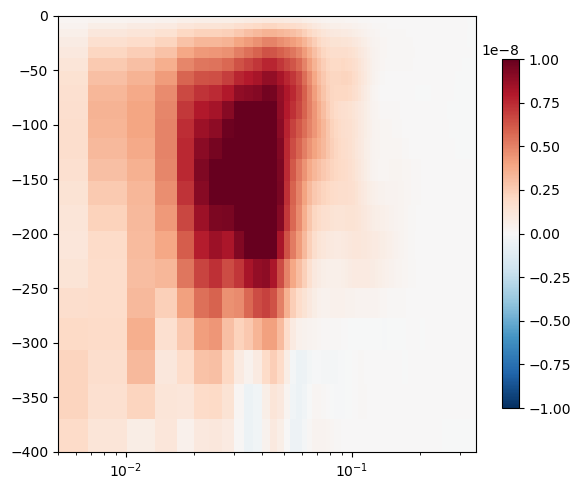

In [21]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(Wwb.scale**-1*1e3, -Wwb.Z, Wwb_int.real*Wwb.scale**-1, 
                   cmap='RdBu_r', rasterized=True,
                   vmax=1e-8, vmin=-1e-8)
ax.set_ylim([-400,0])
ax.set_xlim([5e-3,None])
ax.set_xscale('log')
fig.colorbar(im, ax=ax, shrink=.8)
plt.savefig(op.join(sdir,'Figs/eNATL60-Wwbtot-region%02d-fma.pdf' % reg))

In [7]:
dss = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/W-B_SM_interped_fma.zarr' % reg))
wsp = dss.Ws - dss.Ws.mean(['YC','XC'],skipna=True)
bsp = dss.Bs - dss.Bs.mean(['YC','XC'],skipna=True)

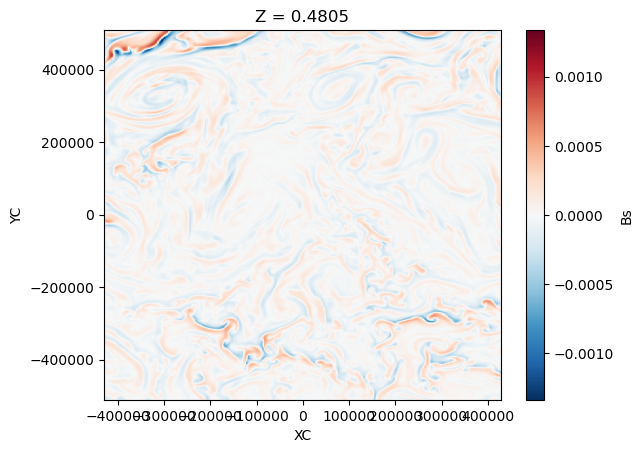

In [21]:
dss.Bs.isel(time=0,Z=3).plot()

In [10]:
maskbs = xr.DataArray(np.ma.masked_invalid(bsp.isel(time=0)).mask,
                     dims=bsp.isel(time=0).dims, coords=bsp.isel(time=0).coords
                    )
Wwsbs = xwavelet.wvlt_cross_spectrum(wsp.where(maskbs!=1.).chunk({'YC':100,'XC':100}), 
                                     bsp.chunk({'YC':100,'XC':100}), 
                                     s, dim=['YC','XC']
                            )
Wwsbs

<xarray.DataArray (time: 9, Z: 36, angle: 8, scale: 106)>
dask.array<truediv, shape=(9, 36, 8, 106), dtype=float64, chunksize=(1, 1, 8, 106), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 0.4805 4.187 9.318 15.89 ... 837.3 885.6 934.9 985.3
  * angle    (angle) float64 0.0 0.3927 0.7854 1.178 1.571 1.963 2.356 2.749
  * scale    (scale) float64 4.496e+05 1.946e+05 ... 2.874e+03 2.847e+03
Dimensions without coordinates: time

In [11]:
dtheta = np.pi/len(Wwsbs.angle)
Wwsbs_int = Wwsbs.sum('angle').mean('time').compute() * dtheta

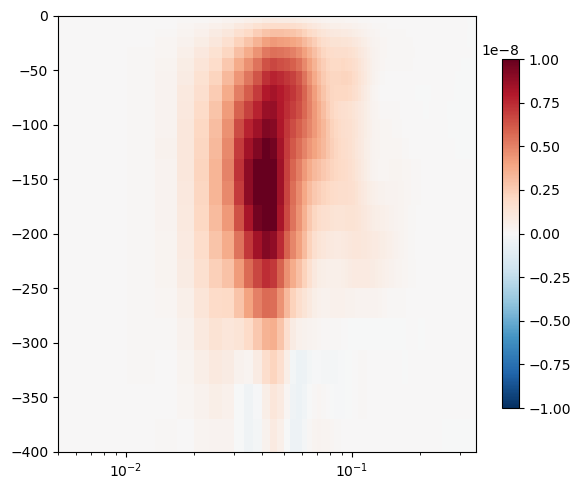

In [14]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(Wwsbs.scale**-1*1e3, -Wwsbs.Z, Wwsbs_int.real*Wwsbs.scale**-1, 
                   cmap='RdBu_r', rasterized=True,
                   vmax=1e-8, vmin=-1e-8)
ax.set_ylim([-400,0])
ax.set_xlim([5e-3,None])
ax.set_xscale('log')
fig.colorbar(im, ax=ax, shrink=.8)
plt.savefig(op.join(sdir,'Figs/eNATL60-Wwsbs-region%02d-fma.pdf' % reg))

In [8]:
dss = xr.open_zarr(op.join(sdir,'eNATL60/region%02d/W-B_SM_interped_fma.zarr' % reg))
wmp = dss.Wm - dss.Wm.mean(['YC','XC'],skipna=True)
bmp = dss.Bm - dss.Bm.mean(['YC','XC'],skipna=True)

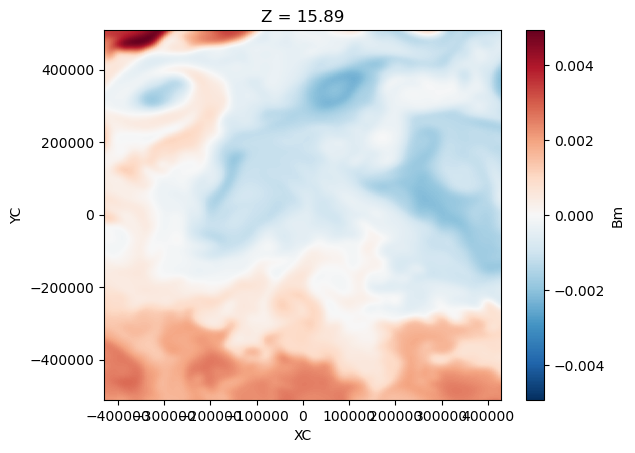

In [9]:
bmp.isel(time=0,Z=3).plot()

In [14]:
maskbm = xr.DataArray(np.ma.masked_invalid(bmp.isel(time=0)).mask,
                     dims=bmp.isel(time=0).dims, coords=bmp.isel(time=0).coords
                    )
Wwmbm = xwavelet.wvlt_cross_spectrum(wmp.where(maskbm!=1.).chunk({'YC':100,'XC':100}), 
                                     bmp.chunk({'YC':100,'XC':100}), 
                                     s, dim=['YC','XC']
                            )
Wwmbm

<xarray.DataArray (time: 9, Z: 36, angle: 8, scale: 106)>
dask.array<truediv, shape=(9, 36, 8, 106), dtype=float64, chunksize=(1, 1, 8, 106), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 0.4805 4.187 9.318 15.89 ... 837.3 885.6 934.9 985.3
  * angle    (angle) float64 0.0 0.3927 0.7854 1.178 1.571 1.963 2.356 2.749
  * scale    (scale) float64 4.496e+05 1.946e+05 ... 2.874e+03 2.847e+03
Dimensions without coordinates: time

In [16]:
dtheta = np.pi/len(Wwmbm.angle)
Wwmbm_int = Wwmbm.sum('angle').mean('time').compute() * dtheta

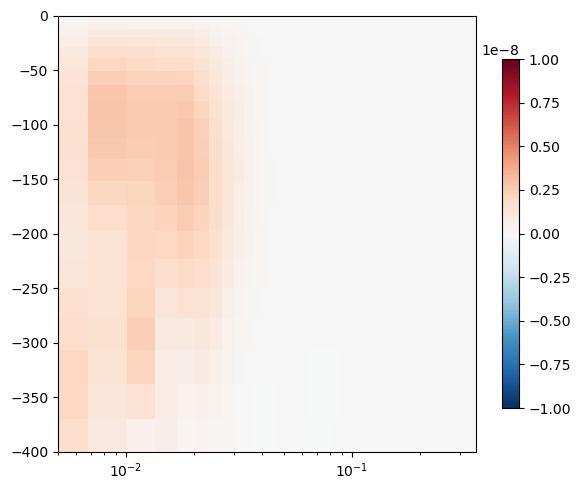

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(Wwmbm.scale**-1*1e3, -Wwmbm.Z, Wwmbm_int.real*Wwmbm.scale**-1, 
                   cmap='RdBu_r', rasterized=True,
                   vmax=1e-8, vmin=-1e-8)
ax.set_ylim([-400,0])
ax.set_xlim([5e-3,None])
ax.set_xscale('log')
fig.colorbar(im, ax=ax, shrink=.8)
plt.savefig(op.join(sdir,'Figs/eNATL60-Wwmbm-region%02d-fma.pdf' % reg))